# Riemannian Fréchet Mean

In [1]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap

from abc import ABC

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

import os

from geometry.riemannian.frechet_mean import GEORCE_FM, GEORCE_AdaFM
from geometry.riemannian.manifolds import nEllipsoid, nSphere, nParaboloid, nEuclidean, T2, RiemannianManifold, FisherRaoGeometry

In [2]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [3]:
figure_path = '../figures/riemannian/frechet/'
seed = 2712

In [4]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Conceptual Method Figure

### Generate data

In [5]:
N_data = 10

In [6]:
M = nSphere(dim=2)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [7]:
theta = jnp.linspace(0, 2*jnp.pi, N_data, endpoint=False)
x_obs = 0.1*jnp.vstack((jnp.cos(theta), jnp.sin(theta), jnp.ones(N_data))).T
x_obs = x_obs.T/jnp.linalg.norm(x_obs, axis=1)
x_obs = x_obs.T

z_obs = vmap(M.invf)(x_obs)

### Computing Fréchet Mean

In [8]:
iters = 3
T = 100
tol = 1e-4
rho = 0.5

In [9]:
FrechetMean = GEORCE_FM(M=M,
                        init_fun=None,
                        T=T,
                        max_iter=iters,
                        tol = tol,
                        line_search_params={'rho': rho},
                       )

In [10]:
fmean = FrechetMean(z_obs, z_mu_init=z_obs[0], step="for")

In [11]:
zt_init = FrechetMean.init_curve(z_obs, z_obs[0])
xt_init = vmap(vmap(M.f))(zt_init)
obj_init = M.length_frechet(zt_init, z_obs, z_obs[0])

In [12]:
xt_geodesics = vmap(vmap(vmap(M.f)))(fmean[1])
xt_fm = vmap(M.f)(fmean[0])
dist = vmap(lambda zt, z_mu: M.length_frechet(zt, z_obs, z_mu))(fmean[1], fmean[0])

### Plotting

In [13]:
class EllipsoidPlot(ABC):
    def __init__(self, params=jnp.linspace(0.5,1.0,3)[::-1]):
        
        self.params = params

    def grid(self, n_points:int=100):
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return self.params[0]*x1,self.params[1]*x2,self.params[2]*x3
         

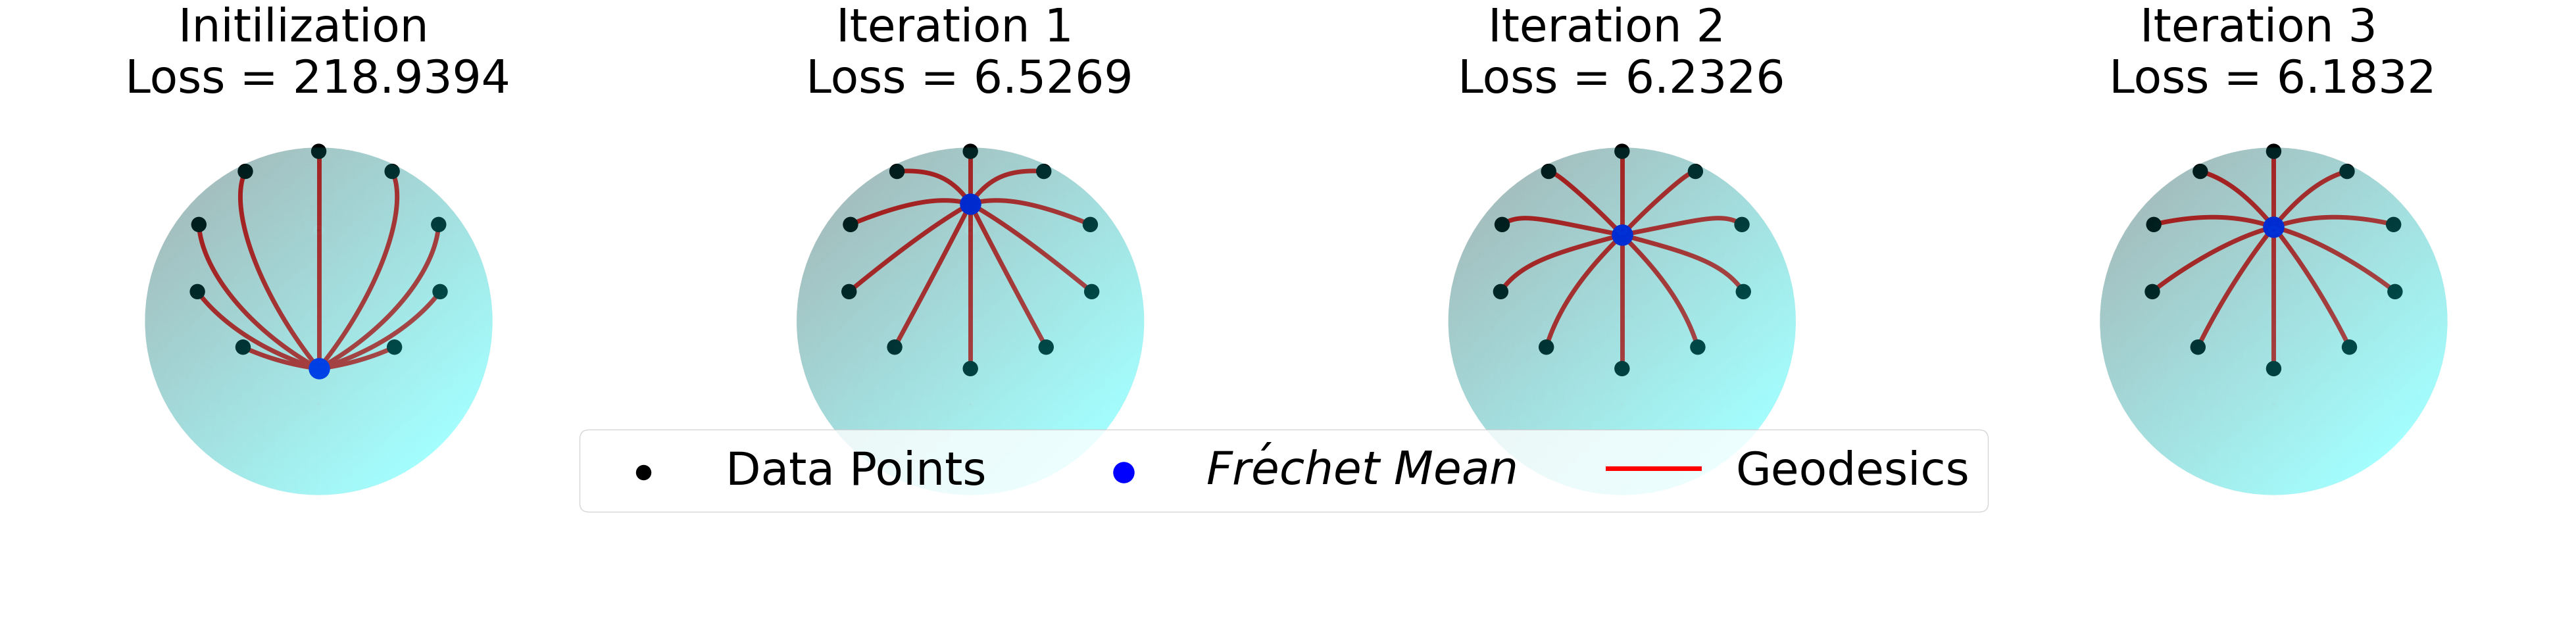

In [14]:
fig = plt.figure(figsize=(40,10))

#plotting sphere
plot_sphere = EllipsoidPlot(params=jnp.ones(3))
x1,x2,x3 = plot_sphere.grid(100)

ax = fig.add_subplot(1,4,1, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)

ax.scatter(x_obs[:,0], x_obs[:,1], x_obs[:,2], color='black', alpha=1.0, s=250)
ax.scatter(x_obs[0,0], x_obs[0,1], x_obs[0,2], color='blue', alpha=1.0, s=500)
for v1 in xt_init:
    ax.plot(v1[:,0], v1[:,1], v1[:,2], color='red', alpha=1.0, linewidth=5.0)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=60., azim=0.)
ax.set_title(f"Initilization \n Loss = {obj_init:.4f}", y=1.0, pad=-20, fontsize=50)

for i in range(3):
    ax = fig.add_subplot(1,4,i+2, projection='3d')
    ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)

    ax.scatter(x_obs[:,0], x_obs[:,1], x_obs[:,2], color='black', alpha=1.0, s=250)
    ax.scatter(xt_fm[i][0], xt_fm[i][1], xt_fm[i][2], color='blue', alpha=1.0, s=500)
    for v1 in xt_geodesics[i]:
        ax.plot(v1[:,0], v1[:,1], v1[:,2], color='red', alpha=1.0, linewidth=5.0)
    ax.set_box_aspect([1,1,1])
    ax.set_xlim([-1.0,1.0])
    ax.set_ylim([-1.0,1.0])
    ax.set_zlim([-1.0,1.0])
    ax.set_axis_off()
    ax.set_title(f"Iteration {i+1} \n Loss = {dist[i]:.4f}", y=1.0, pad=-20, fontsize=50)
    ax.view_init(elev=60., azim=0.)
    
ax.scatter([],[],[], color="black", alpha=1.0, s=250, label="Data Points")
ax.scatter([],[],[], color="blue", alpha=1.0, s=500, label=r"$Fr\'echet$ $Mean$")
ax.plot([],[],[], color="red", alpha=1.0, linewidth=5.0, label=r"Geodesics")

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.225, 0.2), ncol=3, fontsize=50)
    
fig.tight_layout()

save_path = f'{figure_path}conceptual_riemannian_frechet.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()




## Information Geometry with Fisher-Rao metric

In [15]:
N_data = 10

In [16]:
max_iter = 1000
T = 100
tol = 1e-4
rho = 0.95
std = 0.1

### Gaussian Distribution

#### Generate Data

In [17]:
M = FisherRaoGeometry(distribution='Gaussian')
z0 = jnp.array([-1.0, 0.5])
z1 = jnp.array([1.0, 1.0])

In [18]:
key = jrandom.PRNGKey(seed)
eps = std*jrandom.normal(key, shape=(N_data//2, M.dim))

In [19]:
data1 = z0 + jnp.abs(eps)
data2 = z1 + jnp.abs(eps)
gaussian_data = jnp.vstack((data1, data2))

#### Computing Fréchet Mean

In [20]:
FrechetMean = GEORCE_FM(M=M,
                        init_fun=None,
                        T=T,
                        max_iter=max_iter,
                        tol = tol,
                        line_search_params={'rho': rho},
                       )

In [21]:
fgaussian = FrechetMean(gaussian_data, step="while")

In [22]:
gaussian_dist = M.length_frechet(fgaussian[1], gaussian_data, fgaussian[0])

In [23]:
gaussian_pdf = vmap(lambda mu,sigma: vmap(lambda x: \
                                          M.pdf_gaussian(x,
                                                         jnp.hstack((mu,sigma))))(jnp.linspace(mu-3*sigma,
                                                                                               mu+3*sigma,
                                                                                               100)))(gaussian_data[:,0],
                                                                                                      gaussian_data[:,1])

gaussian_grid = vmap(lambda mu, sigma: jnp.linspace(mu-3*sigma,
                                                    mu+3*sigma,
                                                    100))(gaussian_data[:,0],
                                                          gaussian_data[:,1])

In [24]:
mu, sigma = fgaussian[0][0], fgaussian[0][1]
gaussian_fmpdf = vmap(lambda x: M.pdf_gaussian(x,jnp.hstack((mu,sigma))))(jnp.linspace(mu-3*sigma,
                                                                          mu+3*sigma,
                                                                          100))
gaussian_fmgrid = jnp.linspace(mu-3*sigma,mu+3*sigma,100)

### Frechet Distribution

In [25]:
M = FisherRaoGeometry(distribution='Frechet')
z0 = jnp.array([0.5, 0.5])
z1 = jnp.array([1.0, 1.0])

In [26]:
key = jrandom.PRNGKey(seed)
eps = std*jrandom.normal(key, shape=(N_data//2, M.dim))

In [27]:
data1 = z0 + jnp.abs(eps)
data2 = z1 + jnp.abs(eps)
frechet_data = jnp.vstack((data1, data2))

#### Computing Fréchet Mean

In [28]:
FrechetMean = GEORCE_FM(M=M,
                        init_fun=None,
                        T=T,
                        max_iter=max_iter,
                        tol = tol,
                        line_search_params={'rho': rho},
                       )

In [29]:
ffrechet = FrechetMean(frechet_data, step="while")

In [30]:
frechet_dist = M.length_frechet(ffrechet[1], frechet_data, ffrechet[0])

In [31]:
frechet_pdf = vmap(lambda beta,lam: vmap(lambda x: \
                                 M.pdf_frechet(x,jnp.hstack((beta,lam))))(jnp.linspace(0.01,
                                                                                    3.0,
                                                                                        100)))(frechet_data[:,0],
                                                                                               frechet_data[:,1])
frechet_grid = vmap(lambda beta, lam: jnp.linspace(0.01,
                                             3.0,
                                             100))(frechet_data[:,0],
                                                   frechet_data[:,1])

In [32]:
beta, lam = ffrechet[0][0], ffrechet[0][1]
frechet_fmpdf =  vmap(lambda x: M.pdf_frechet(x,jnp.hstack((beta,lam))))(jnp.linspace(0.01,3.0,100))
frechet_fmgrid = jnp.linspace(0.01,3.0,100)

### Cauchy Distribution

In [33]:
M = FisherRaoGeometry(distribution='Cauchy')
z0 = jnp.array([-1.0, 0.5])
z1 = jnp.array([1.0, 1.0])

In [34]:
key = jrandom.PRNGKey(seed)
eps = std*jrandom.normal(key, shape=(N_data//2, M.dim))

In [35]:
data1 = z0 + jnp.abs(eps)
data2 = z1 + jnp.abs(eps)
cauchy_data = jnp.vstack((data1, data2))

#### Computing Fréchet Mean

In [36]:
FrechetMean = GEORCE_FM(M=M,
                        init_fun=None,
                        T=T,
                        max_iter=max_iter,
                        tol = 1e-4,
                        line_search_params={'rho': rho},
                       )

In [37]:
fcauchy = FrechetMean(cauchy_data, step="while")

In [38]:
cauchy_dist = M.length_frechet(fcauchy[1], cauchy_data, fcauchy[0])

In [39]:
cauchy_pdf = vmap(lambda mu,sigma: vmap(lambda x: \
                                          M.pdf_cauchy(x,
                                                       jnp.hstack((mu,sigma))))(jnp.linspace(mu-3*sigma,
                                                                                             mu+3*sigma,
                                                                                             100)))(cauchy_data[:,0],
                                                                                                    cauchy_data[:,1])
cauchy_grid = vmap(lambda mu, sigma: jnp.linspace(mu-3*sigma,
                                                  mu+3*sigma,
                                                  100))(cauchy_data[:,0],
                                                        cauchy_data[:,1])

In [40]:
mu, sigma = fcauchy[0][0], fcauchy[0][1]
cauchy_fmpdf =  vmap(lambda x: M.pdf_cauchy(x,jnp.hstack((mu,sigma))))(jnp.linspace(mu-3*sigma,
                                                                                    mu+3*sigma,
                                                                                    100))
cauchy_fmgrid = jnp.linspace(mu-3*sigma,mu+3*sigma,100)

### Pareto Distribution

In [41]:
M = FisherRaoGeometry(distribution='Pareto')
z0 = jnp.array([0.5, 0.5])
z1 = jnp.array([1.0, 1.0])

In [42]:
key = jrandom.PRNGKey(seed)
eps = 0.5*jrandom.normal(key, shape=(N_data//2, M.dim))

In [43]:
data1 = z0 + jnp.abs(eps)
data2 = z1 + jnp.abs(eps)
pareto_data = jnp.vstack((data1, data2))

#### Computing Fréchet Mean

In [44]:
FrechetMean = GEORCE_FM(M=M,
                        init_fun=None,
                        T=T,
                        max_iter=max_iter,
                        tol = tol,
                        line_search_params={'rho': rho},
                       )

In [45]:
fpareto = FrechetMean(pareto_data, step="while")

In [46]:
pareto_dist = M.length_frechet(fpareto[1], pareto_data, fpareto[0])

In [47]:
pareto_pdf = vmap(lambda theta,alpha: vmap(lambda x: \
                                 M.pdf_pareto(x,jnp.hstack((theta,alpha))))(jnp.linspace(0.5,
                                                                                        2.0,
                                                                                        100)))(pareto_data[:,0],
                                                                                               pareto_data[:,1])
pareto_grid = vmap(lambda theta, alpha: jnp.linspace(0.5,
                                             2.0,
                                             100))(pareto_data[:,0],
                                                   pareto_data[:,1])

In [48]:
theta, alpha = fpareto[0][0], fpareto[0][1]
pareto_fmpdf =  vmap(lambda x: M.pdf_pareto(x,jnp.hstack((theta,alpha))))(jnp.linspace(0.5,
                                                                                        2.0,
                                                                                        100))
pareto_fmgrid = jnp.linspace(0.5,2.0,100)

### Plotting

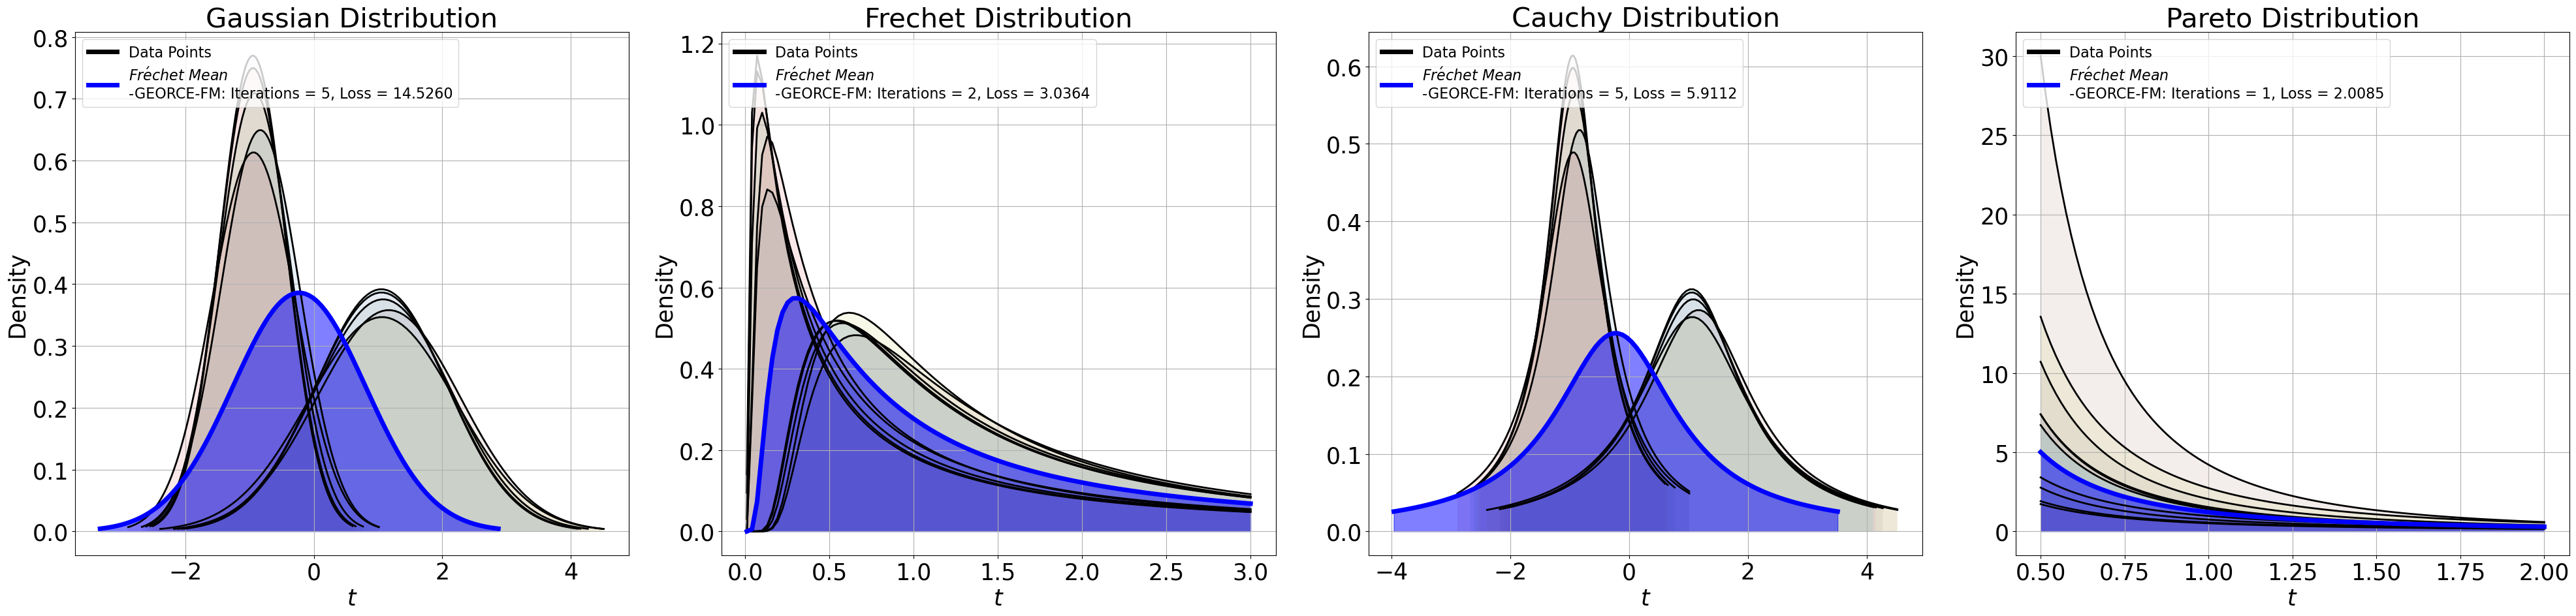

In [49]:
fig = plt.figure(figsize=(40,10))

#Gaussian
ax = fig.add_subplot(141)
for grid, pdf in zip(gaussian_grid, gaussian_pdf):
    ax.plot(grid, pdf, color='black', linewidth=2.0)
    ax.fill_between(grid, 
                    pdf,
                    alpha=0.1,
                    )
    
ax.plot([], [], color='black', linewidth=5.0, label="Data Points")
ax.plot(gaussian_fmgrid, gaussian_fmpdf, color='blue', linewidth=5.0, label=r"$Fr\'echet$ $Mean$" + \
       f"\n-GEORCE-FM: Iterations = {fgaussian[-1]}, Loss = {gaussian_dist:.4f}")
ax.fill_between(gaussian_fmgrid, 
                gaussian_fmpdf,
                color="blue",
                alpha=0.5,
                )
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'Density')
ax.legend(loc=2, prop={'size': 16})
ax.set_title(f'Gaussian Distribution')
ax.grid(True)

#Frechet
ax = fig.add_subplot(142)
for grid, pdf in zip(frechet_grid, frechet_pdf):
    ax.plot(grid, pdf, color='black', linewidth=2.0)
    ax.fill_between(grid, 
                    pdf,
                    alpha=0.1,
                    )
    
ax.plot([], [], color='black', linewidth=5.0, label="Data Points")
ax.plot(frechet_fmgrid, frechet_fmpdf, color='blue', linewidth=5.0, label=r"$Fr\'echet$ $Mean$" + \
       f"\n-GEORCE-FM: Iterations = {ffrechet[-1]}, Loss = {frechet_dist:.4f}")
ax.fill_between(frechet_fmgrid, 
                frechet_fmpdf,
                color="blue",
                alpha=0.5,
                )
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'Density')
ax.legend(loc=2, prop={'size': 16})
ax.set_title(f'Frechet Distribution')
ax.grid(True)

#Cauchy
ax = fig.add_subplot(143)
for grid, pdf in zip(cauchy_grid, cauchy_pdf):
    ax.plot(grid, pdf, color='black', linewidth=2.0)
    ax.fill_between(grid, 
                    pdf,
                    alpha=0.1,
                    )
    
ax.plot([], [], color='black', linewidth=5.0, label="Data Points")
ax.plot(cauchy_fmgrid, cauchy_fmpdf, color='blue', linewidth=5.0, label=r"$Fr\'echet$ $Mean$" + \
       f"\n-GEORCE-FM: Iterations = {fcauchy[-1]}, Loss = {cauchy_dist:.4f}")
ax.fill_between(cauchy_fmgrid, 
                cauchy_fmpdf,
                color="blue",
                alpha=0.5,
                )
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'Density')
ax.legend(loc=2, prop={'size': 16})
ax.set_title(f'Cauchy Distribution')
ax.grid(True)

#Pareto
ax = fig.add_subplot(144)
for grid, pdf in zip(pareto_grid, pareto_pdf):
    ax.plot(grid, pdf, color='black', linewidth=2.0)
    ax.fill_between(grid, 
                    pdf,
                    alpha=0.1,
                    )
    
ax.plot([], [], color='black', linewidth=5.0, label="Data Points")
ax.plot(pareto_fmgrid, pareto_fmpdf, color='blue', linewidth=5.0, label=r"$Fr\'echet$ $Mean$" + \
       f"\n-GEORCE-FM: Iterations = {fpareto[-1]}, Loss = {pareto_dist:.4f}")
ax.fill_between(pareto_fmgrid, 
                pareto_fmpdf,
                color="blue",
                alpha=0.5,
                )
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'Density')
ax.legend(loc=2, prop={'size': 16})
ax.set_title(f'Pareto Distribution')
ax.grid(True)

fig.tight_layout()
save_path = f'{figure_path}information_geometry_frechet_mean.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()